In [3]:
import tensorflow as tf 
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 

In [4]:
ImageSize =256 
BatchSize =32 

In [5]:
dataset = tf.keras.preprocessing .image_dataset_from_directory(
    "PlantVillage" ,
    shuffle=True,
    image_size=(ImageSize,ImageSize) ,
    batch_size = BatchSize
)
    


Found 2152 files belonging to 3 classes.


In [6]:
class_names =dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
68*32

2176

In [9]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
for img_batch , label_batch in dataset.take(1):
    print (img_batch[0])
    print (label_batch.shape)

tf.Tensor(
[[[140. 130. 141.]
  [139. 129. 140.]
  [137. 127. 138.]
  ...
  [146. 139. 147.]
  [148. 141. 149.]
  [143. 136. 144.]]

 [[138. 128. 139.]
  [138. 128. 139.]
  [135. 125. 136.]
  ...
  [147. 140. 148.]
  [150. 143. 151.]
  [145. 138. 146.]]

 [[136. 126. 137.]
  [136. 126. 137.]
  [133. 123. 134.]
  ...
  [148. 141. 149.]
  [150. 143. 151.]
  [146. 139. 147.]]

 ...

 [[120. 112. 125.]
  [119. 111. 124.]
  [121. 113. 126.]
  ...
  [143. 135. 148.]
  [133. 125. 138.]
  [131. 123. 136.]]

 [[122. 114. 127.]
  [121. 113. 126.]
  [122. 114. 127.]
  ...
  [144. 136. 149.]
  [134. 126. 139.]
  [133. 125. 138.]]

 [[127. 119. 132.]
  [126. 118. 131.]
  [125. 117. 130.]
  ...
  [138. 130. 143.]
  [128. 120. 133.]
  [128. 120. 133.]]], shape=(256, 256, 3), dtype=float32)
(32,)


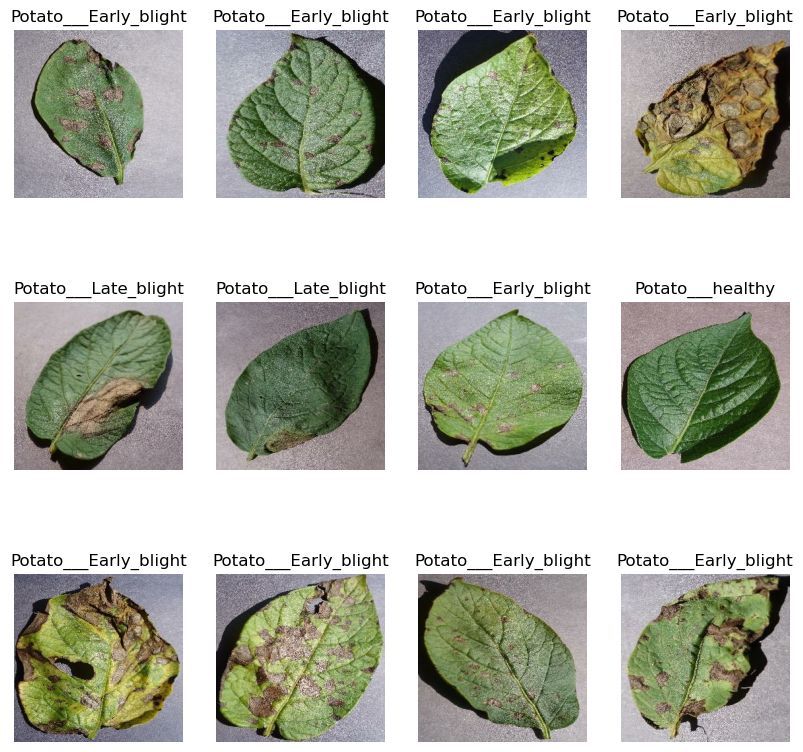

In [54]:
plt.figure(figsize=(10,10))
for img_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.axis('off')
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
    


### 80% ==> training 
### 20% ==> 10% validation , 10% test

In [61]:
train_size = 0.8
len(dataset)*train_size 

54.400000000000006

In [65]:
train_Ds = dataset.take(54)
len(train_Ds)

54

In [67]:
test = dataset.skip(54)
len(test)

14

In [71]:
val_Ds = test.take(7)
test_Ds = test.skip(7)

In [81]:
def get_dataset_partitions_tf(ds , train_split= 0.8 , val_split = 0.1 , test_split= 0.1 , shuffle=True , shuffle_size = 1000 ):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size, seed =12)
        # what does seed do???????
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_Ds = ds.take(train_size)
    
    val_Ds = ds.skip(train_size).take(val_size) 
    test_Ds = ds.skip(train_size).skip(val_size)

    return train_Ds , val_Ds , test_Ds 



In [83]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [85]:
len(train_ds)

54

In [89]:
#cache stores the data in cache for the next epoch 
# prefetch--> CPU fetches the next batch while GPU is trining the current batch (but you dont have a GPU :)  )
# buffer_size lets it decide how many batch to load while GPU is training

In [91]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [99]:
# train_ds = train_ds.map(lambda x: x/255)
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

In [103]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical") , 
    layers.RandomRotation(0.2) 
])